In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

Name: 
Type: DiGraph
Number of nodes: 78
Number of edges: 80
Average in degree:   1.0256
Average out degree:   1.0256


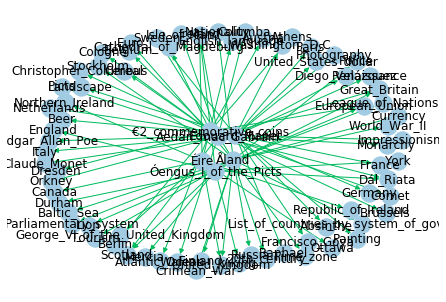

In [19]:
#g = nx.read_edgelist("data/decoded.tsv")

#print(nx.info(g))
pd.read_csv('data/decoded.tsv',nrows=80, delimiter='\t').to_csv('data/decodedSample.tsv', sep='\t',header=False,index=False)

#reading the edgelist in a variable using networkX
subgraph=nx.read_edgelist('data/decodedSample.tsv',delimiter='\t',create_using=nx.DiGraph())
#plotting the graph
print(nx.info(subgraph))
pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")